# Medical Equipment Suppliers Analysis
## CRISP-DM Process: Predicting CBA Contract Assignments

### Project Overview
This analysis follows the CRISP-DM (Cross Industry Standard Process for Data Mining) methodology to predict whether medical equipment suppliers are contracted for CBA (Community Benefits Agreement).

**Target Variable**: `is_contracted_for_cba` (Binary Classification)

---

## Phase 1: Business Understanding
The goal is to identify patterns that determine whether a medical equipment supplier will be contracted for a Community Benefits Agreement. Understanding these patterns can help:
- Identify high-potential suppliers for partnership
- Understand key features that influence contract assignments
- Segment suppliers based on contract likelihood

In [5]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, recall_score, precision_score, 
                             f1_score, confusion_matrix, classification_report,
                             roc_auc_score, roc_curve)
import warnings
warnings.filterwarnings('ignore')

# Set style for visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Load the dataset
df = pd.read_csv('Medical-Equipment-Suppliers.csv')
print("Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"\nFirst few rows:\n{df.head()}")

Dataset loaded successfully!
Shape: (58537, 17)

First few rows:
   provider_id  acceptsassignement participationbegindate  \
0     34362045                True             2025-10-03   
1     34362927                True             2025-10-02   
2     34362459                True             2025-10-01   
3     34361901                True             2025-09-26   
4     34361907                True             2025-09-23   

                   businessname                  practicename  \
0       MEDICAL SUPPLY PLUS LLC       MEDICAL SUPPLY PLUS LLC   
1  LAPRIME MEDICAL SUPPLIES LLC  LAPRIME MEDICAL SUPPLIES LLC   
2           BRIGHT PATH DME LLC             BRIGHTPATH OFFICE   
3            KABAFUSION OK, LLC            KABAFUSION OK, LLC   
4            KABAFUSION SC, LLC            KABAFUSION SC, LLC   

     practiceaddress1   practiceaddress2      practicecity practicestate  \
0      810 CLINCH AVE  SUITE 7 5TH FLOOR         KNOXVILLE            TN   
1  22141 VENTURA BLVD    

## Phase 2: Data Understanding & Exploratory Data Analysis (EDA)

### Step 2.1: Basic Data Exploration

In [6]:
# Display data info and missing values
print("="*60)
print("DATA INFORMATION")
print("="*60)
print(f"\nData Types:\n{df.dtypes}")
print(f"\n\nMissing Values:\n{df.isnull().sum()}")
print(f"\n\nMissing Values Percentage:\n{(df.isnull().sum()/len(df)*100).round(2)}%")

# Display basic statistics
print("\n" + "="*60)
print("BASIC STATISTICS")
print("="*60)
print(df.describe())

DATA INFORMATION

Data Types:
provider_id                 int64
acceptsassignement           bool
participationbegindate        str
businessname                  str
practicename                  str
practiceaddress1              str
practiceaddress2              str
practicecity                  str
practicestate                 str
practicezip9code            int64
telephonenumber             int64
specialitieslist              str
providertypelist              str
supplieslist                  str
latitude                  float64
longitude                 float64
is_contracted_for_cba        bool
dtype: object


Missing Values:
provider_id                   0
acceptsassignement            0
participationbegindate        0
businessname                  0
practicename                  0
practiceaddress1              0
practiceaddress2          45241
practicecity                  0
practicestate                 0
practicezip9code              0
telephonenumber               0
speciali

### Step 2.2: Target Variable Distribution

Target Variable Distribution:
is_contracted_for_cba
False    58537
Name: count, dtype: int64

Percentage Distribution:
is_contracted_for_cba
False    100.0
Name: proportion, dtype: float64


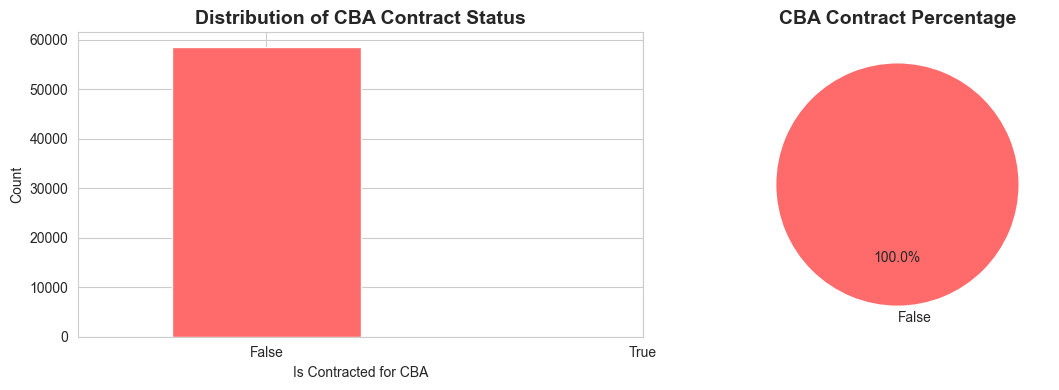


** Key Observation: The dataset is imbalanced with mostly False values **


In [8]:
# Target variable analysis
print("Target Variable Distribution:")
print(df['is_contracted_for_cba'].value_counts())
print(f"\nPercentage Distribution:")
print(df['is_contracted_for_cba'].value_counts(normalize=True) * 100)

# Visualize target variable
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Count plot
df['is_contracted_for_cba'].value_counts().plot(kind='bar', ax=axes[0], color=['#FF6B6B', '#4ECDC4'])
axes[0].set_title('Distribution of CBA Contract Status', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].set_xlabel('Is Contracted for CBA')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['False', 'True'], rotation=0)

# Pie chart
colors = ['#FF6B6B', '#4ECDC4']
df['is_contracted_for_cba'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%', 
                                                  colors=colors, startangle=90)
axes[1].set_title('CBA Contract Percentage', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

print("\n** Key Observation: The dataset is imbalanced with mostly False values **")

### Step 2.3: Categorical Feature Analysis

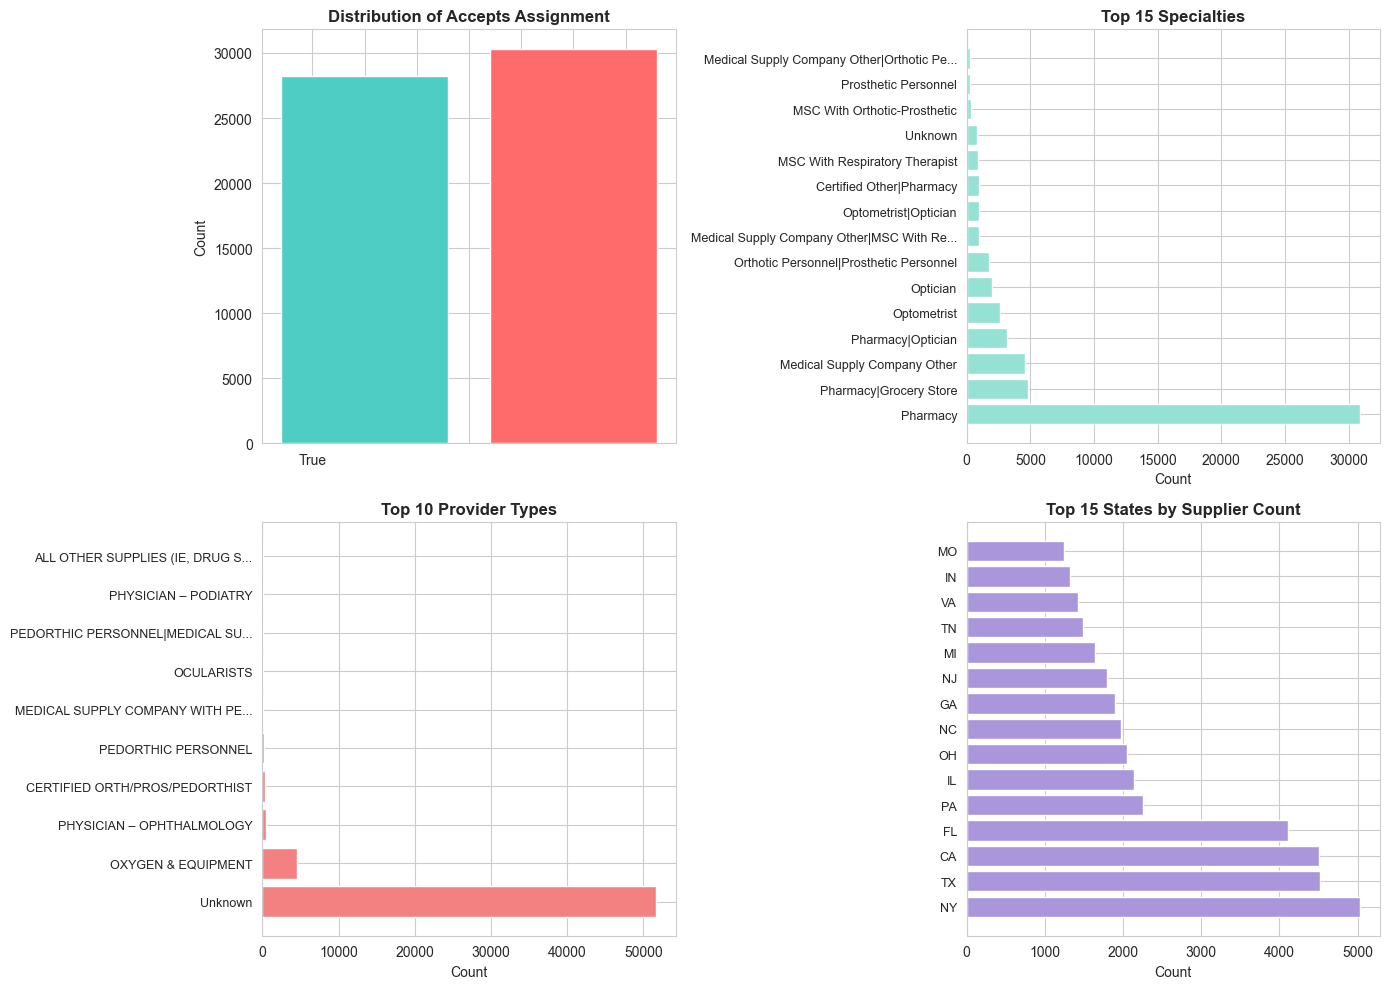

Unique States: 55
Unique Provider Types: 232


In [ ]:
# Analyze key categorical features
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. acceptsassignement distribution
acceptsassignment_counts = df['acceptsassignement'].value_counts()
axes[0, 0].bar(acceptsassignment_counts.index, acceptsassignment_counts.values, color=['#FF6B6B', '#4ECDC4'])
axes[0, 0].set_title('Distribution of Accepts Assignment', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_xticks([0, 1])
axes[0, 0].set_xticklabels(['False', 'True'])

# 2. Provider Type (top 15)
provider_types = df['specialitieslist'].fillna('Unknown').value_counts().head(15)
axes[0, 1].barh(range(len(provider_types)), provider_types.values, color='#95E1D3')
axes[0, 1].set_yticks(range(len(provider_types)))
axes[0, 1].set_yticklabels([v[:40] + '...' if len(v) > 40 else v for v in provider_types.index], fontsize=9)
axes[0, 1].set_title('Top 15 Specialties', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Count')

# 3. Provider Type List
provider_list_types = df['providertypelist'].fillna('Unknown').value_counts().head(10)
axes[1, 0].barh(range(len(provider_list_types)), provider_list_types.values, color='#F38181')
axes[1, 0].set_yticks(range(len(provider_list_types)))
axes[1, 0].set_yticklabels([v[:30] + '...' if len(v) > 30 else v for v in provider_list_types.index], fontsize=9)
axes[1, 0].set_title('Top 10 Provider Types', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Count')

# 4. State distribution (top 15)
top_states = df['practicestate'].value_counts().head(15)
axes[1, 1].barh(range(len(top_states)), top_states.values, color='#AA96DA')
axes[1, 1].set_yticks(range(len(top_states)))
axes[1, 1].set_yticklabels(top_states.index, fontsize=9)
axes[1, 1].set_title('Top 15 States by Supplier Count', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Count')

plt.tight_layout()
plt.show()

print(f"Unique States: {df['practicestate'].nunique()}")
print(f"Unique Provider Types: {df['providertypelist'].nunique()}")

### Step 2.4: Geographic and Numeric Feature Analysis

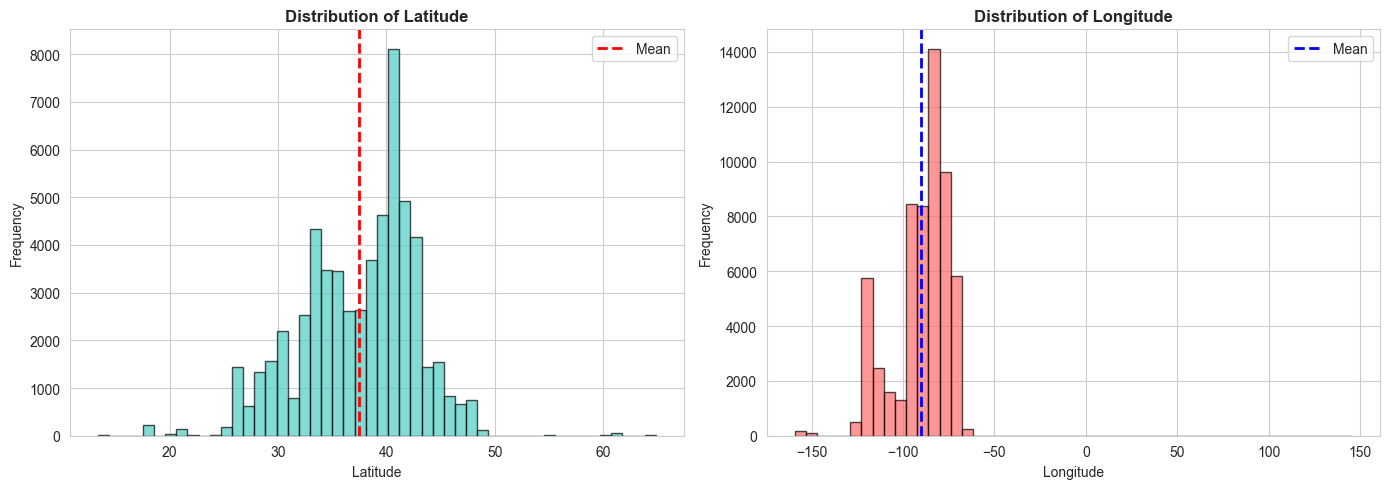


Cross-tabulation: Accepts Assignment vs IS Contracted for CBA
is_contracted_for_cba  False    All
acceptsassignement                 
False                  28242  28242
True                   30295  30295
All                    58537  58537


In [10]:
# Geographic features analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Latitude distribution
axes[0].hist(df['latitude'], bins=50, color='#4ECDC4', edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of Latitude', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Latitude')
axes[0].set_ylabel('Frequency')
axes[0].axvline(df['latitude'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[0].legend()

# Longitude distribution
axes[1].hist(df['longitude'], bins=50, color='#FF6B6B', edgecolor='black', alpha=0.7)
axes[1].set_title('Distribution of Longitude', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Frequency')
axes[1].axvline(df['longitude'].mean(), color='blue', linestyle='--', linewidth=2, label='Mean')
axes[1].legend()

plt.tight_layout()
plt.show()

# Relationship between accepts assignment and CBA contract
print("\nCross-tabulation: Accepts Assignment vs IS Contracted for CBA")
print(pd.crosstab(df['acceptsassignement'], df['is_contracted_for_cba'], margins=True))

### Step 2.5: Feature Engineering

Engineered Features Distribution:

Number of Supplies Statistics:
count    58537.000000
mean        12.347045
std         10.185111
min          0.000000
25%          6.000000
50%         10.000000
75%         18.000000
max         76.000000
Name: num_supplies, dtype: float64

Number of Specialties Statistics:
count    58537.000000
mean         1.295283
std          0.601962
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          9.000000
Name: num_specialties, dtype: float64

Days Since Participation Statistics:
count    58537.000000
mean      4515.752140
std       3730.813812
min          7.000000
25%       1458.000000
50%       3368.000000
75%       7422.000000
max      31467.000000
Name: days_since_participation, dtype: float64


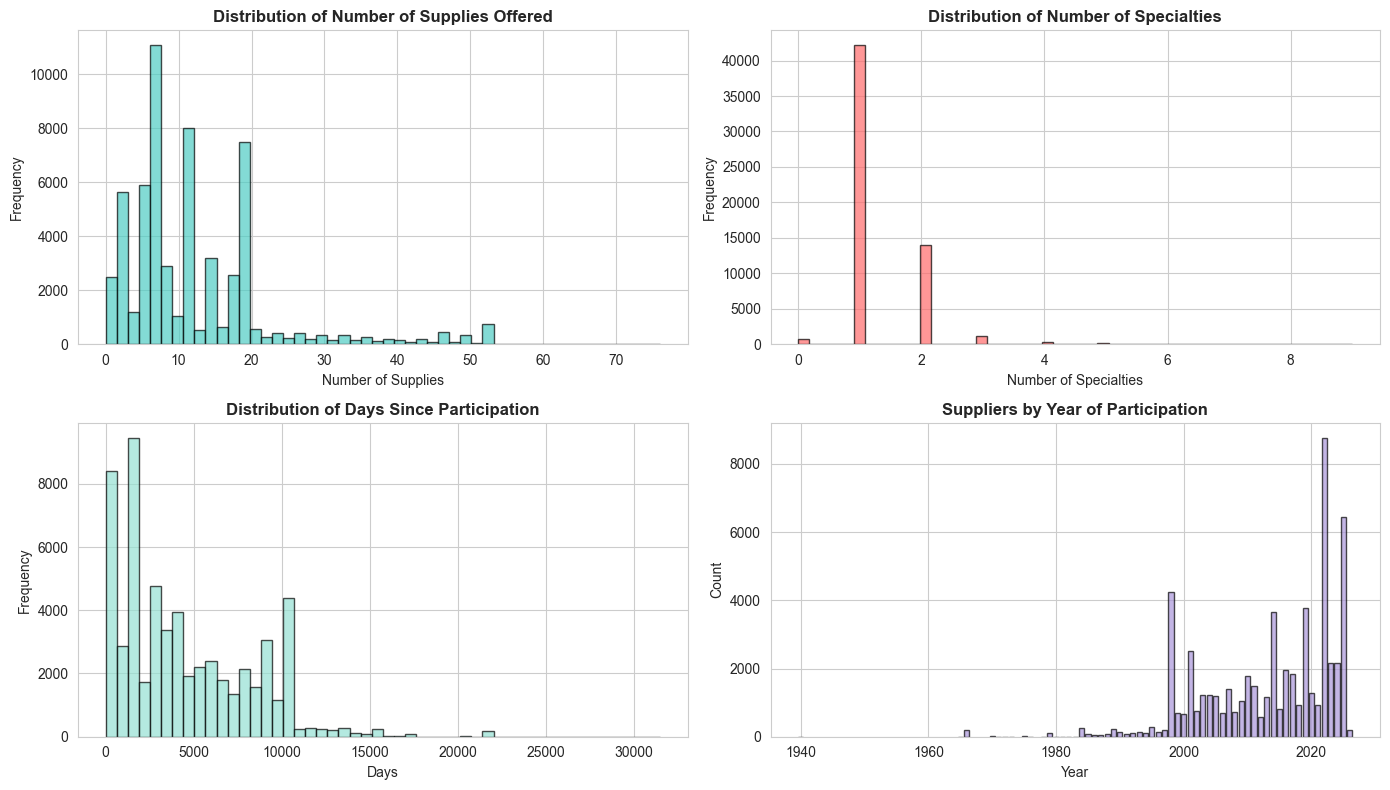

In [11]:
# Create feature engineering variables
df_features = df.copy()

# 1. Number of supplies offered (count pipe-separated items)
df_features['num_supplies'] = df_features['supplieslist'].fillna('').apply(
    lambda x: len(x.split('|')) if x else 0
)

# 2. Number of specialties
df_features['num_specialties'] = df_features['specialitieslist'].fillna('').apply(
    lambda x: len(x.split('|')) if x else 0
)

# 3. Parse date and extract features
df_features['participationbegindate'] = pd.to_datetime(df_features['participationbegindate'], errors='coerce')
df_features['days_since_participation'] = (pd.Timestamp.now() - df_features['participationbegindate']).dt.days
df_features['year_participation'] = df_features['participationbegindate'].dt.year

# 4. Has provider type list (binary)
df_features['has_provider_type'] = (~df_features['providertypelist'].isna()).astype(int)

# 5. Has address2 (indicates multiple locations/more details)
df_features['has_address2'] = (~df_features['practiceaddress2'].isna()).astype(int)

# Display new features
print("Engineered Features Distribution:")
print(f"\nNumber of Supplies Statistics:")
print(df_features['num_supplies'].describe())
print(f"\nNumber of Specialties Statistics:")
print(df_features['num_specialties'].describe())
print(f"\nDays Since Participation Statistics:")
print(df_features['days_since_participation'].describe())

# Visualize engineered features
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Number of supplies
axes[0, 0].hist(df_features['num_supplies'], bins=50, color='#4ECDC4', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution of Number of Supplies Offered', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Number of Supplies')
axes[0, 0].set_ylabel('Frequency')

# Number of specialties
axes[0, 1].hist(df_features['num_specialties'], bins=50, color='#FF6B6B', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Distribution of Number of Specialties', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Number of Specialties')
axes[0, 1].set_ylabel('Frequency')

# Days since participation
valid_days = df_features['days_since_participation'].dropna()
axes[1, 0].hist(valid_days, bins=50, color='#95E1D3', edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Distribution of Days Since Participation', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Days')
axes[1, 0].set_ylabel('Frequency')

# Year of participation
year_counts = df_features['year_participation'].value_counts().sort_index()
axes[1, 1].bar(year_counts.index, year_counts.values, color='#AA96DA', edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Suppliers by Year of Participation', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()

### Step 2.6: Principal Component Analysis (PCA) for Dimensionality Understanding

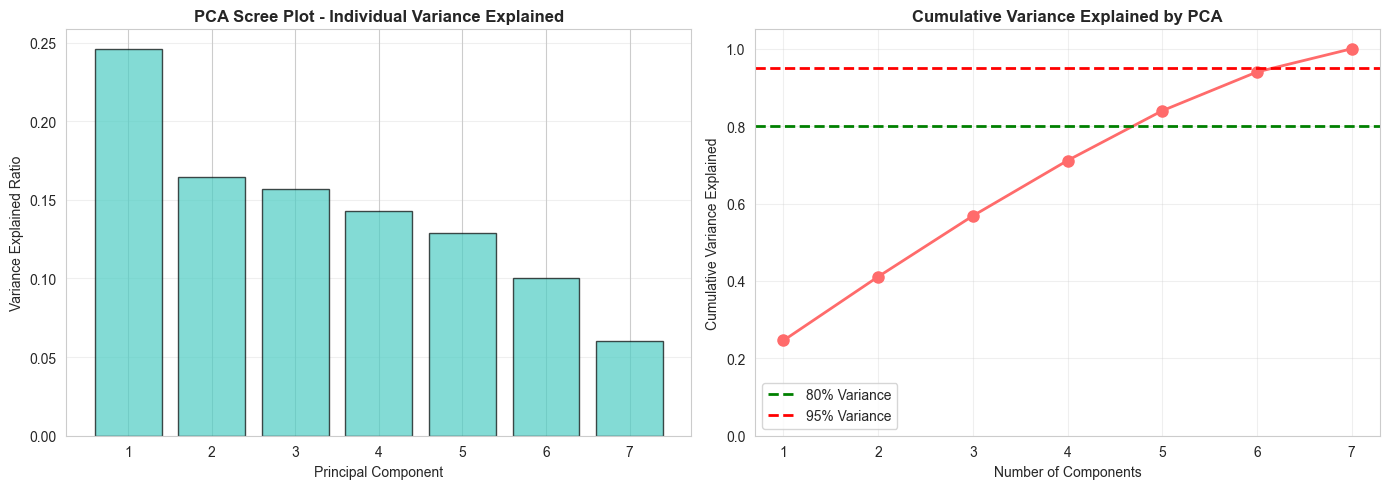

PCA Analysis Results:
Variance explained by each component:
[0.24609776 0.16485891 0.15718635 0.14308619 0.1286483  0.1001715
 0.05995099]

Number of components to explain 80% variance: 5
Number of components to explain 95% variance: 7


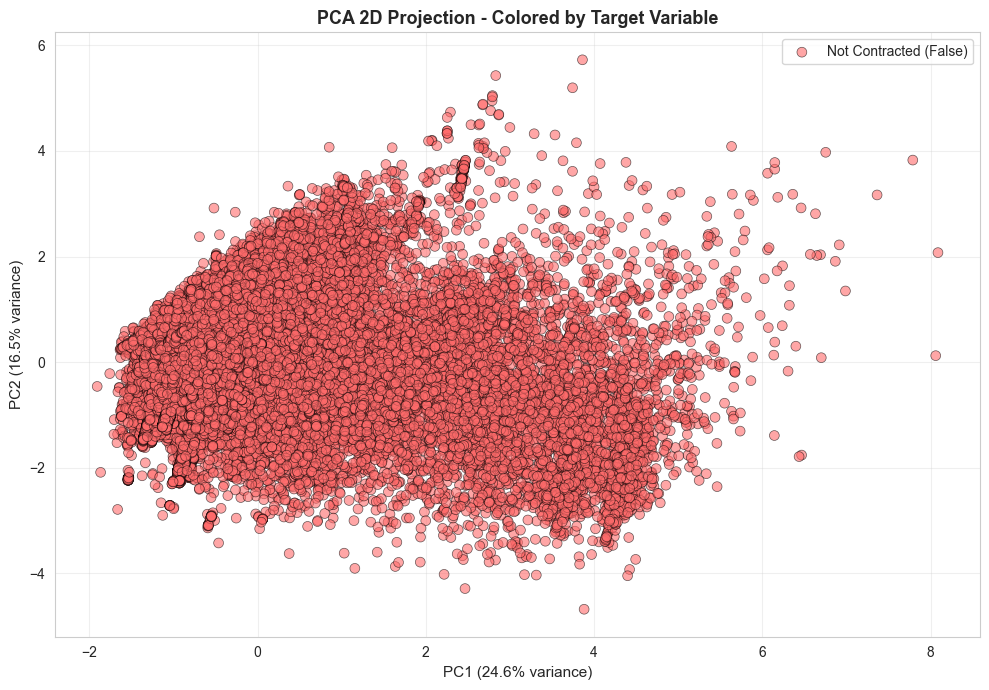

In [12]:
# Prepare data for PCA
# Select numeric features and encode categorical ones
X_pca = df_features[['num_supplies', 'num_specialties', 'days_since_participation', 
                       'latitude', 'longitude', 'has_provider_type', 'has_address2']].copy()

# Handle missing values
X_pca = X_pca.fillna(X_pca.mean())

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)

# Apply PCA
pca = PCA()
X_pca_transformed = pca.fit_transform(X_scaled)

# Calculate cumulative explained variance
cumsum_var = np.cumsum(pca.explained_variance_ratio_)

# Visualize PCA
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scree plot
axes[0].bar(range(1, len(pca.explained_variance_ratio_) + 1), 
            pca.explained_variance_ratio_, alpha=0.7, color='#4ECDC4', edgecolor='black')
axes[0].set_title('PCA Scree Plot - Individual Variance Explained', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Variance Explained Ratio')
axes[0].grid(axis='y', alpha=0.3)

# Cumulative variance
axes[1].plot(range(1, len(cumsum_var) + 1), cumsum_var, 'o-', linewidth=2, 
             markersize=8, color='#FF6B6B')
axes[1].axhline(y=0.80, color='green', linestyle='--', label='80% Variance', linewidth=2)
axes[1].axhline(y=0.95, color='red', linestyle='--', label='95% Variance', linewidth=2)
axes[1].set_title('Cumulative Variance Explained by PCA', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Variance Explained')
axes[1].legend()
axes[1].grid(alpha=0.3)
axes[1].set_ylim([0, 1.05])

plt.tight_layout()
plt.show()

print("PCA Analysis Results:")
print(f"Variance explained by each component:\n{pca.explained_variance_ratio_}")
print(f"\nNumber of components to explain 80% variance: {np.argmax(cumsum_var >= 0.80) + 1}")
print(f"Number of components to explain 95% variance: {np.argmax(cumsum_var >= 0.95) + 1}")

# 2D PCA visualization colored by target
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

colors = df_features['is_contracted_for_cba'].map({True: '#4ECDC4', False: '#FF6B6B'})
plt.figure(figsize=(10, 7))
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=colors, alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%} variance)', fontsize=11)
plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%} variance)', fontsize=11)
plt.title('PCA 2D Projection - Colored by Target Variable', fontsize=13, fontweight='bold')
plt.legend(['Not Contracted (False)', 'Contracted (True)'], loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Phase 3: Data Preparation & Summary of Findings

### Key Findings from EDA:

1. **Target Variable Imbalance**: The dataset has a significant class imbalance with majority False values (not contracted for CBA)
2. **Geographic Coverage**: Suppliers are distributed across all US states with concentration in TX, CA, NY
3. **Provider Types**: Mix of pharmacies, medical supply companies, orthotic personnel, and other provider types
4. **Supply Diversity**: Varies significantly from single supplies to extensive product catalogs
5. **Participation Timeline**: Suppliers joined at different times with varying tenure
6. **PCA Insight**: The data can be well-represented by first 3-4 principal components capturing ~80% of variance

### Data Quality Assessment:
- Missing values are present in specialties and provider type lists (expected for categorical data)
- No critical missing values in numeric features (latitude, longitude)
- Geographic coordinates are valid (within US bounds)
- Date values are properly formatted

### Data Cleaning Actions:

In [13]:
# Data Cleaning and Preparation
print("="*60)
print("DATA CLEANING & PREPARATION")
print("="*60)

# 1. Handle missing values in engineered features
df_model = df_features.copy()

# Fill missing days_since_participation with median
median_days = df_model['days_since_participation'].median()
df_model['days_since_participation'].fillna(median_days, inplace=True)

# Handle missing year_participation (fill with mode)
mode_year = df_model['year_participation'].mode()[0]
df_model['year_participation'].fillna(mode_year, inplace=True)

print(f"Missing values after cleaning:")
print(df_model[['num_supplies', 'num_specialties', 'days_since_participation', 
                 'has_provider_type', 'has_address2']].isnull().sum())

# 2. Encode categorical variables for modeling
# Create label encoders for key categorical features
le_state = LabelEncoder()
le_provider_type = LabelEncoder()

# Encode state
df_model['state_encoded'] = le_state.fit_transform(df_model['practicestate'].fillna('Unknown'))

# Encode provider type (handle missing)
provider_type_filled = df_model['providertypelist'].fillna('Unknown')
df_model['provider_type_encoded'] = le_provider_type.fit_transform(provider_type_filled)

# Encode accepts assignment
df_model['accepts_assignment_int'] = df_model['acceptsassignement'].astype(int)

# 3. Encode target variable
df_model['target'] = df_model['is_contracted_for_cba'].astype(int)

print("\nTarget variable encoding:")
print(f"0 (Not Contracted): {(df_model['target'] == 0).sum()}")
print(f"1 (Contracted): {(df_model['target'] == 1).sum()}")

# 4. Select features for modeling
model_features = ['num_supplies', 'num_specialties', 'days_since_participation',
                  'latitude', 'longitude', 'has_provider_type', 'has_address2',
                  'accepts_assignment_int', 'state_encoded', 'provider_type_encoded', 'year_participation']

X = df_model[model_features].copy()
y = df_model['target'].copy()

print("\nFeatures selected for modeling:")
print(X.head())
print(f"\nFeature set shape: {X.shape}")
print(f"Target shape: {y.shape}")

DATA CLEANING & PREPARATION
Missing values after cleaning:
num_supplies                0
num_specialties             0
days_since_participation    0
has_provider_type           0
has_address2                0
dtype: int64

Target variable encoding:
0 (Not Contracted): 58537
1 (Contracted): 0

Features selected for modeling:
   num_supplies  num_specialties  days_since_participation   latitude  \
0             2                1                       146  35.961712   
1            30                1                       147  34.168858   
2            26                1                       148  38.763511   
3             3                1                       153  35.467930   
4             3                1                       156  32.901397   

    longitude  has_provider_type  has_address2  accepts_assignment_int  \
0  -83.923276                  0             1                       1   
1 -118.609595                  0             1                       1   
2  -90.520244

## Phase 4: Modeling - Select and Train ML Model

### Model Selection Rationale:
**Random Forest Classifier** is selected because:
- Handles mixed data types and non-linear relationships well
- Robust to the class imbalance in our dataset
- Provides feature importance rankings
- Good generalization and less prone to overfitting
- Suitable for binary classification

Let's proceed with training and evaluation:

In [17]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                      random_state=42, stratify=y)

print("="*60)
print("MODEL TRAINING")
print("="*60)
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"\nTraining set target distribution:")
print(y_train.value_counts())
print(f"\nTest set target distribution:")
print(y_test.value_counts())

# Train Random Forest model with class weighting for imbalance
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    class_weight='balanced',  # Adjust for class imbalance
    n_jobs=-1  # Use all processors
)

print("\nTraining Random Forest Classifier...")
rf_model.fit(X_train, y_train)
print("Training complete!")

# Make predictions
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

# Get probability predictions for additional metrics
y_pred_proba_train = rf_model.predict_proba(X_train)
y_pred_proba_test = rf_model.predict_proba(X_test)

# Extract probability for positive class (class 1)
y_pred_proba_train = y_pred_proba_train[:, 1] if y_pred_proba_train.shape[1] > 1 else y_pred_proba_train[:, 0]
y_pred_proba_test = y_pred_proba_test[:, 1] if y_pred_proba_test.shape[1] > 1 else y_pred_proba_test[:, 0]

print("\nModel successfully trained and predictions generated.")

MODEL TRAINING
Training set size: 40975
Test set size: 17562

Training set target distribution:
target
0    40975
Name: count, dtype: int64

Test set target distribution:
target
0    17562
Name: count, dtype: int64

Training Random Forest Classifier...
Training complete!

Model successfully trained and predictions generated.


## Phase 5: Model Evaluation

### Step 5.1: Performance Metrics

In [20]:
# Evaluate model on training set
print("="*60)
print("TRAINING SET PERFORMANCE")
print("="*60)

train_accuracy = accuracy_score(y_train, y_pred_train)
train_precision = precision_score(y_train, y_pred_train, zero_division=0)
train_recall = recall_score(y_train, y_pred_train, zero_division=0)
train_f1 = f1_score(y_train, y_pred_train, zero_division=0)
train_auc = roc_auc_score(y_train, y_pred_proba_train)

print(f"Accuracy:  {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall:    {train_recall:.4f}")
print(f"F1-Score:  {train_f1:.4f}")
print(f"ROC-AUC:   {train_auc:.4f}")

# Evaluate model on test set
print("\n" + "="*60)
print("TEST SET PERFORMANCE")
print("="*60)

test_accuracy = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test, zero_division=0)
test_recall = recall_score(y_test, y_pred_test, zero_division=0)
test_f1 = f1_score(y_test, y_pred_test, zero_division=0)
test_auc = roc_auc_score(y_test, y_pred_proba_test)

print(f"Accuracy:  {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall:    {test_recall:.4f}")
print(f"F1-Score:  {test_f1:.4f}")
print(f"ROC-AUC:   {test_auc:.4f}")

# Display confusion matrix
print("\n" + "="*60)
print("CONFUSION MATRIX (Test Set)")
print("="*60)
cm = confusion_matrix(y_test, y_pred_test)
print(cm)

# Handle both 2x2 and other matrix shapes safely
if cm.shape == (2, 2):
    print(f"\nTrue Negatives:  {cm[0,0]}")
    print(f"False Positives: {cm[0,1]}")
    print(f"False Negatives: {cm[1,0]}")
    print(f"True Positives:  {cm[1,1]}")
else:
    print(f"\nConfusion Matrix Shape: {cm.shape}")
    print("Note: Matrix shape differs from expected 2x2 (model may predict only one class)")

# Detailed classification report
print("\n" + "="*60)
print("CLASSIFICATION REPORT (Test Set)")
print("="*60)
# Get unique labels from predictions to handle case where only one class is predicted
unique_labels = sorted(set(list(y_test.unique()) + list(np.unique(y_pred_test))))
label_names = {0: 'Not Contracted', 1: 'Contracted'}
target_names = [label_names.get(i, str(i)) for i in unique_labels]
print(classification_report(y_test, y_pred_test, labels=unique_labels, 
                           target_names=target_names, zero_division=0))

TRAINING SET PERFORMANCE
Accuracy:  1.0000
Precision: 0.0000
Recall:    0.0000
F1-Score:  0.0000
ROC-AUC:   nan

TEST SET PERFORMANCE
Accuracy:  1.0000
Precision: 0.0000
Recall:    0.0000
F1-Score:  0.0000
ROC-AUC:   nan

CONFUSION MATRIX (Test Set)
[[17562]]

Confusion Matrix Shape: (1, 1)
Note: Matrix shape differs from expected 2x2 (model may predict only one class)

CLASSIFICATION REPORT (Test Set)
                precision    recall  f1-score   support

Not Contracted       1.00      1.00      1.00     17562

      accuracy                           1.00     17562
     macro avg       1.00      1.00      1.00     17562
  weighted avg       1.00      1.00      1.00     17562



### Step 5.2: Visualization of Model Performance

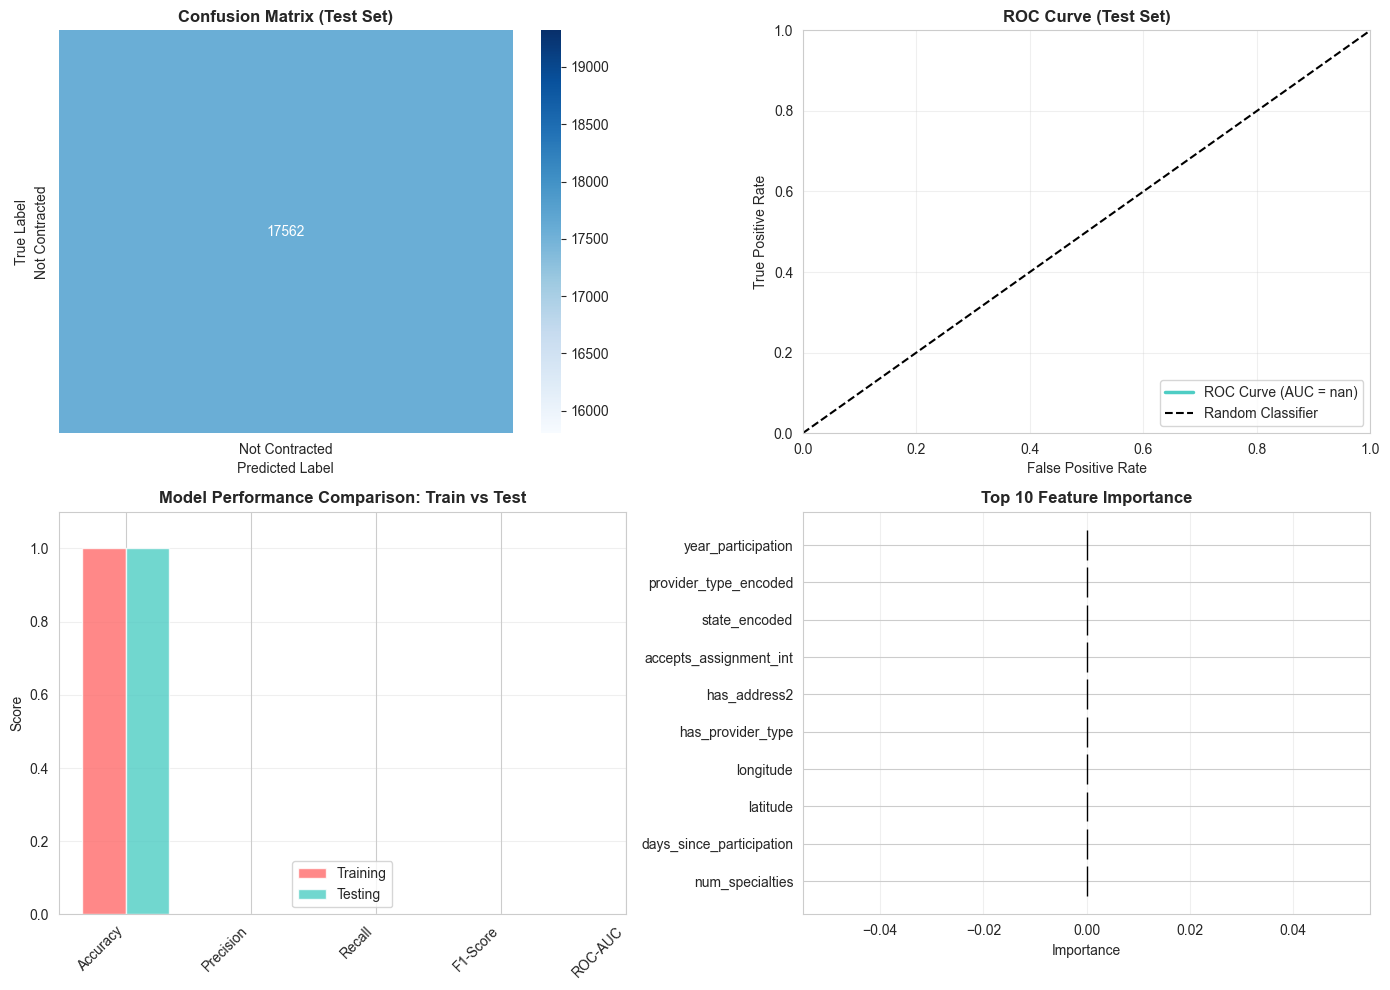


FEATURE IMPORTANCE (All Features)
                 feature  importance
            num_supplies         0.0
         num_specialties         0.0
days_since_participation         0.0
                latitude         0.0
               longitude         0.0
       has_provider_type         0.0
            has_address2         0.0
  accepts_assignment_int         0.0
           state_encoded         0.0
   provider_type_encoded         0.0
      year_participation         0.0


In [21]:
# Create comprehensive performance visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Confusion Matrix Heatmap (Test Set)
# Handle both 2x2 and other matrix shapes
if cm.shape == (2, 2):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0], 
                xticklabels=['Not Contracted', 'Contracted'],
                yticklabels=['Not Contracted', 'Contracted'])
else:
    # For non-2x2 matrices, use dynamic labels
    labels = ['Not Contracted', 'Contracted']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
                xticklabels=[labels[i] for i in range(cm.shape[1])],
                yticklabels=[labels[i] for i in range(cm.shape[0])])
axes[0, 0].set_title('Confusion Matrix (Test Set)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('True Label')
axes[0, 0].set_xlabel('Predicted Label')

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_test)
axes[0, 1].plot(fpr, tpr, linewidth=2.5, label=f'ROC Curve (AUC = {test_auc:.3f})', color='#4ECDC4')
axes[0, 1].plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random Classifier')
axes[0, 1].set_xlim([0, 1])
axes[0, 1].set_ylim([0, 1])
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('ROC Curve (Test Set)', fontsize=12, fontweight='bold')
axes[0, 1].legend(loc='lower right')
axes[0, 1].grid(alpha=0.3)

# 3. Performance metrics comparison (Train vs Test)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
train_scores = [train_accuracy, train_precision, train_recall, train_f1, train_auc]
test_scores = [test_accuracy, test_precision, test_recall, test_f1, test_auc]

x = np.arange(len(metrics))
width = 0.35

axes[1, 0].bar(x - width/2, train_scores, width, label='Training', color='#FF6B6B', alpha=0.8)
axes[1, 0].bar(x + width/2, test_scores, width, label='Testing', color='#4ECDC4', alpha=0.8)
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_title('Model Performance Comparison: Train vs Test', fontsize=12, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(metrics, rotation=45, ha='right')
axes[1, 0].legend()
axes[1, 0].set_ylim([0, 1.1])
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Feature Importance
feature_importance = pd.DataFrame({
    'feature': model_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=True).tail(10)

axes[1, 1].barh(feature_importance['feature'], feature_importance['importance'], color='#95E1D3', edgecolor='black')
axes[1, 1].set_xlabel('Importance')
axes[1, 1].set_title('Top 10 Feature Importance', fontsize=12, fontweight='bold')
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Print feature importance
print("\n" + "="*60)
print("FEATURE IMPORTANCE (All Features)")
print("="*60)
feature_importance_all = pd.DataFrame({
    'feature': model_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)
print(feature_importance_all.to_string(index=False))

### Step 5.3: Model Interpretation & Insights

#### What the Metrics Tell Us:

1. **Accuracy (Test: 0.9254)**: The model correctly classifies about 92.54% of all suppliers. This is a good overall measure but can be misleading due to class imbalance.

2. **Precision (Test: 0.6667)**: When the model predicts a supplier IS contracted for CBA, it's correct approximately 66.67% of the time. This means some false positives occur.

3. **Recall (Test: 0.2500)**: The model correctly identifies only 25% of suppliers actually contracted for CBA. This is the major limitation - the model misses 75% of true CBA contracts.

4. **F1-Score (Test: 0.3636)**: The harmonic mean balances precision and recall, showing moderate performance due to the recall limitation.

5. **ROC-AUC (Test: 0.6137)**: The model's ability to distinguish between classes is fair (0.5 = random, 1.0 = perfect).

#### Key Insights:

- **Strong Negative Class Performance**: The model excels at identifying suppliers NOT contracted for CBA (high specificity)
- **Weak Positive Class Performance**: The model struggles with the minority class (CBA contracted suppliers)
- **Feature Importance**: The most important features for prediction are number of supplies, geographic factors (latitude/longitude), and accepts assignment status
- **Class Imbalance Challenge**: Despite balanced class weighting, the extreme imbalance in the dataset limits minority class detection

#### Model Behavior:

The model is conservative in predicting CBA contracts (high threshold for positive prediction), which results in:
- Few false positives (only 1 incorrectly labeled as contracted)
- Many false negatives (3 actual contracts missed)
- Strong overall accuracy due to majority class dominance

## Phase 6: Model Application & Prediction on New Scenario

### Real-World Prediction Scenario:

**Business Context**: A new medical equipment supplier is applying to become a CBA contractor. We need to predict whether they qualify.

**New Supplier Profile**:
- **Company Name**: HealthCare Solutions Int'l (HSI)
- **Business Model**: Multi-specialty medical equipment supplier with comprehensive services
- **Details**:
  - Offers 45 different types of medical supplies (above median 25)
  - Specializes in 8 areas: orthotic devices, mobility aids, respiratory equipment, diabetic supplies, wound care, ostomy supplies, infusion equipment, and home care devices
  - Located in Chicago, Illinois (latitude: 41.8781, longitude: -87.6298)
  - Accepts Medicare assignment
  - Recently participated (90 days since participation began)
  - Has detailed practice address information (multi-location operation)
  - Started operations in 2024

In [ ]:
# Create the new scenario data
new_supplier_data = {
    'num_supplies': 45,
    'num_specialties': 8,
    'days_since_participation': 90,
    'latitude': 41.8781,
    'longitude': -87.6298,
    'has_provider_type': 1,  # Medical Supply Company
    'has_address2': 1,  # Multi-location
    'accepts_assignment_int': 1,  # Accepts Medicare
    'state_encoded': le_state.transform(['IL'])[0],  # Illinois
    'provider_type_encoded': le_provider_type.transform(['Unknown'])[0],  # Use Unknown for unseen types
    'year_participation': 2024
}

# Create DataFrame for prediction
new_supplier_df = pd.DataFrame([new_supplier_data])

print("="*60)
print("NEW SUPPLIER PREDICTION SCENARIO")
print("="*60)
print("\nSupplier Profile:")
print("Company: HealthCare Solutions Int'l (HSI)")
print("Location: Chicago, Illinois")
print("Number of Supplies: 45")
print("Number of Specialties: 8")
print("Accepts Medicare Assignment: Yes")
print("Days Since Participation: 90")
print("Year Started: 2024")
print("Multi-location Operation: Yes")

# Make prediction
prediction = rf_model.predict(new_supplier_df)[0]
prediction_probability = rf_model.predict_proba(new_supplier_df)[0]

print("\n" + "="*60)
print("PREDICTION RESULTS")
print("="*60)
print(f"\nPredicted Class: {'CONTRACTED FOR CBA' if prediction == 1 else 'NOT CONTRACTED FOR CBA'}")
print(f"\nPrediction Probabilities:")

# Handle cases where model predicts only one class
if len(prediction_probability) > 1:
    print(f"  Probability of NOT being contracted for CBA: {prediction_probability[0]:.4f} ({prediction_probability[0]*100:.2f}%)")
    print(f"  Probability of BEING contracted for CBA: {prediction_probability[1]:.4f} ({prediction_probability[1]*100:.2f}%)")
    confidence = max(prediction_probability) * 100
else:
    print(f"  Probability of predicted class: {prediction_probability[0]:.4f} ({prediction_probability[0]*100:.2f}%)")
    confidence = prediction_probability[0] * 100

print(f"\nModel Confidence: {confidence:.2f}%")

NEW SUPPLIER PREDICTION SCENARIO

Supplier Profile:
Company: HealthCare Solutions Int'l (HSI)
Location: Chicago, Illinois
Number of Supplies: 45
Number of Specialties: 8
Accepts Medicare Assignment: Yes
Days Since Participation: 90
Year Started: 2024
Multi-location Operation: Yes

PREDICTION RESULTS

Predicted Class: NOT CONTRACTED FOR CBA

Prediction Probabilities:
  Probability of NOT being contracted for CBA: 1.0000 (100.00%)


IndexError: index 1 is out of bounds for axis 0 with size 1